In [1]:
import numpy as np
from scipy import sparse
import pandas as pd
import xgboost as xgb
import re
import string
import time
import seaborn as sns
import itertools
import lightgbm as lgb 
from bayes_opt import BayesianOptimization
import seaborn as sns
import matplotlib.pyplot as plt

import random
from sklearn import preprocessing, pipeline, metrics, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neural_network import MLPClassifier
from IPython.display import display
import datetime

%matplotlib inline 



/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_data = pd.read_csv('../input/air_visit_data.csv')
air_store_info = pd.read_csv('../input/air_store_info.csv')
hpg_store_info = pd.read_csv('../input/hpg_store_info.csv')
air_reserve = pd.read_csv('../input/air_reserve.csv')
hpg_reserve = pd.read_csv('../input/hpg_reserve.csv')
store_id_relation = pd.read_csv('../input/store_id_relation.csv')
test_data = pd.read_csv('../input/sample_submission.csv')
date_info = pd.read_csv('../input/date_info.csv').rename(columns={'calendar_date':'visit_date'})
train_size = train_data.shape[0]

In [3]:
test_data['visit_date'] = test_data['id'].map(lambda x: str(x).split('_')[2])
test_data['air_store_id'] = test_data['id'].map(lambda x: '_'.join(x.split('_')[:2]))

In [45]:
test_data.head()

,id,visitors,visit_date,air_store_id
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9


In [4]:
full_data = pd.concat([train_data,test_data])

In [5]:
full_data['visit_date'] = pd.to_datetime(full_data['visit_date'])
full_data['dow'] = full_data['visit_date'].dt.dayofweek
full_data['year'] = full_data['visit_date'].dt.year
full_data['month'] = full_data['visit_date'].dt.month
full_data['doy'] = full_data['visit_date'].dt.dayofyear
full_data['dom'] = full_data['visit_date'].dt.days_in_month
full_data['woy'] = full_data['visit_date'].dt.weekofyear
full_data['is_month_end'] = full_data['visit_date'].dt.is_month_end
full_data['visit_date'] = full_data['visit_date'].dt.date
full_data['date_int'] = full_data['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)

In [6]:
air_store_info['air_area_lv1'] = air_store_info.air_area_name.apply(lambda x:x.split(' ')[0])
air_store_info['air_area_lv2'] = air_store_info.air_area_name.apply(lambda x:x.split(' ')[1])
air_store_info['air_area_lv3'] = air_store_info.air_area_name.apply(lambda x:x.split(' ')[2])

hpg_store_info['hpg_area_lv1'] = hpg_store_info.hpg_area_name.apply(lambda x:x.split(' ')[0])
hpg_store_info['hpg_area_lv2'] = hpg_store_info.hpg_area_name.apply(lambda x:x.split(' ')[1])
hpg_store_info['hpg_area_lv3'] = hpg_store_info.hpg_area_name.apply(lambda x:x.split(' ')[2])

In [7]:
air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby(['latitude','longitude']).air_store_id.count().\
                                    reset_index().rename(columns={'air_store_id':'air_stores_on_same_addr'}),
                             how='left',
                             on=['latitude','longitude'])


air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby('air_area_lv1').air_store_id.count().\
                                    reset_index().rename(columns={'air_store_id':'air_stores_lv1'}),
                             how='left',
                             on='air_area_lv1')

air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby(['air_area_lv1','air_area_lv2']).air_store_id.count().\
                                    reset_index().rename(columns={'air_store_id':'air_stores_lv2'}),
                             how='left',
                             on=['air_area_lv1','air_area_lv2'])


air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby('air_area_lv1').latitude.mean().\
                                    reset_index().rename(columns={'latitude':'mean_lat_air_lv1'}),
                             how='left',
                             on='air_area_lv1')

air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby('air_area_lv1').latitude.max().\
                                    reset_index().rename(columns={'latitude':'max_lat_air_lv1'}),
                             how='left',
                             on='air_area_lv1')

air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby('air_area_lv1').latitude.min().\
                                    reset_index().rename(columns={'latitude':'min_lat_air_lv1'}),
                             how='left',
                             on='air_area_lv1')


air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby('air_area_lv1').longitude.mean().\
                                    reset_index().rename(columns={'longitude':'mean_lon_air_lv1'}),
                             how='left',
                             on='air_area_lv1')

air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby('air_area_lv1').longitude.max().\
                                    reset_index().rename(columns={'longitude':'max_lon_air_lv1'}),
                             how='left',
                             on='air_area_lv1')

air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby('air_area_lv1').longitude.min().\
                                    reset_index().rename(columns={'longitude':'min_lon_air_lv1'}),
                             how='left',
                             on='air_area_lv1')

air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby(['air_area_lv1','air_area_lv2']).latitude.mean().\
                                    reset_index().rename(columns={'latitude':'mean_lat_air_lv2'}),
                             how='left',
                             on=['air_area_lv1','air_area_lv2'])

air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby(['air_area_lv1','air_area_lv2']).latitude.max().\
                                    reset_index().rename(columns={'latitude':'max_lat_air_lv2'}),
                             how='left',
                             on=['air_area_lv1','air_area_lv2'])

air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby(['air_area_lv1','air_area_lv2']).latitude.min().\
                                    reset_index().rename(columns={'latitude':'min_lat_air_lv2'}),
                             how='left',
                             on=['air_area_lv1','air_area_lv2'])


air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby(['air_area_lv1','air_area_lv2']).longitude.mean().\
                                    reset_index().rename(columns={'longitude':'mean_lon_air_lv2'}),
                             how='left',
                             on=['air_area_lv1','air_area_lv2'])

air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby(['air_area_lv1','air_area_lv2']).longitude.max().\
                                    reset_index().rename(columns={'longitude':'max_lon_air_lv2'}),
                             how='left',
                             on=['air_area_lv1','air_area_lv2'])

air_store_info = pd.merge(air_store_info,
                             air_store_info.groupby(['air_area_lv1','air_area_lv2']).longitude.min().\
                                    reset_index().rename(columns={'longitude':'min_lon_air_lv2'}),
                             how='left',
                             on=['air_area_lv1','air_area_lv2'])


hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby(['latitude','longitude']).hpg_store_id.count().\
                                    reset_index().rename(columns={'hpg_store_id':'hpg_stores_on_same_addr'}),
                             how='left',
                             on=['latitude','longitude'])


hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby('hpg_area_lv1').hpg_store_id.count().\
                                    reset_index().rename(columns={'hpg_store_id':'hpg_stores_lv1'}),
                             how='left',
                             on='hpg_area_lv1')

hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby(['hpg_area_lv1','hpg_area_lv2']).hpg_store_id.count().\
                                    reset_index().rename(columns={'hpg_store_id':'hpg_stores_lv2'}),
                             how='left',
                             on=['hpg_area_lv1','hpg_area_lv2'])


hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby('hpg_area_lv1').latitude.mean().\
                                    reset_index().rename(columns={'latitude':'mean_lat_hpg_lv1'}),
                             how='left',
                             on='hpg_area_lv1')

hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby('hpg_area_lv1').latitude.max().\
                                    reset_index().rename(columns={'latitude':'max_lat_hpg_lv1'}),
                             how='left',
                             on='hpg_area_lv1')

hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby('hpg_area_lv1').latitude.min().\
                                    reset_index().rename(columns={'latitude':'min_lat_hpg_lv1'}),
                             how='left',
                             on='hpg_area_lv1')


hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby('hpg_area_lv1').longitude.mean().\
                                    reset_index().rename(columns={'longitude':'mean_lon_hpg_lv1'}),
                             how='left',
                             on='hpg_area_lv1')

hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby('hpg_area_lv1').longitude.max().\
                                    reset_index().rename(columns={'longitude':'max_lon_hpg_lv1'}),
                             how='left',
                             on='hpg_area_lv1')

hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby('hpg_area_lv1').longitude.min().\
                                    reset_index().rename(columns={'longitude':'min_lon_hpg_lv1'}),
                             how='left',
                             on='hpg_area_lv1')

hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby(['hpg_area_lv1','hpg_area_lv2']).latitude.mean().\
                                    reset_index().rename(columns={'latitude':'mean_lat_hpg_lv2'}),
                             how='left',
                             on=['hpg_area_lv1','hpg_area_lv2'])

hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby(['hpg_area_lv1','hpg_area_lv2']).latitude.max().\
                                    reset_index().rename(columns={'latitude':'max_lat_hpg_lv2'}),
                             how='left',
                             on=['hpg_area_lv1','hpg_area_lv2'])

hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby(['hpg_area_lv1','hpg_area_lv2']).latitude.min().\
                                    reset_index().rename(columns={'latitude':'min_lat_hpg_lv2'}),
                             how='left',
                             on=['hpg_area_lv1','hpg_area_lv2'])


hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby(['hpg_area_lv1','hpg_area_lv2']).longitude.mean().\
                                    reset_index().rename(columns={'longitude':'mean_lon_hpg_lv2'}),
                             how='left',
                             on=['hpg_area_lv1','hpg_area_lv2'])

hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby(['hpg_area_lv1','hpg_area_lv2']).longitude.max().\
                                    reset_index().rename(columns={'longitude':'max_lon_hpg_lv2'}),
                             how='left',
                             on=['hpg_area_lv1','hpg_area_lv2'])

hpg_store_info = pd.merge(hpg_store_info,
                             hpg_store_info.groupby(['hpg_area_lv1','hpg_area_lv2']).longitude.min().\
                                    reset_index().rename(columns={'longitude':'min_lon_hpg_lv2'}),
                             how='left',
                             on=['hpg_area_lv1','hpg_area_lv2'])

In [8]:
air_store_info = pd.merge(air_store_info, store_id_relation, how='left', on='air_store_id')
air_store_info = pd.merge(air_store_info, hpg_store_info, how='left', on='hpg_store_id')
air_store_info = air_store_info.rename(columns={'latitude_x':'latitude_air',
                             'longitude_x':'longitude_air',
                             'latitude_y':'latitude_hpg',
                             'longitude_y':'longitude_hpg'})



In [9]:
full_data = pd.merge(full_data, air_store_info, how='left', on='air_store_id')

In [10]:
air_reserve['visit_date'] = air_reserve['visit_datetime'].apply(lambda x:x[:10])
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].apply(lambda x:x[:10])
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve['reserve_datetime'])
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].dt.date
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['visit_date'] = air_reserve['visit_datetime'].dt.date
air_reserve['reserve_datetime_diff'] = air_reserve.apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).seconds 
                                                         * r['reserve_visitors']/3600/24.0, axis=1)


hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].apply(lambda x:x[:10])
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].apply(lambda x:x[:10])
hpg_reserve['reserve_datetime'] = pd.to_datetime(hpg_reserve['reserve_datetime'])
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].dt.date
hpg_reserve['visit_datetime'] = pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].dt.date
hpg_reserve['reserve_datetime_diff'] = hpg_reserve.apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).seconds
                                                         * r['reserve_visitors']/3600/24.0, axis=1)



In [11]:
air_reserve_grp = air_reserve.groupby(['air_store_id','visit_date'])['reserve_visitors','reserve_datetime_diff'].\
            sum().reset_index().rename(columns={'reserve_visitors':'air_rvs',
                                               'reserve_datetime_diff':'air_rv_dt_diff'})
hpg_reserve_grp = hpg_reserve.groupby(['hpg_store_id','visit_date'])['reserve_visitors','reserve_datetime_diff'].\
            sum().reset_index().rename(columns={'reserve_visitors':'hpg_rvs',
                                               'reserve_datetime_diff':'hpg_rv_dt_diff'})
air_reserve_grp['mean_air_rv_dt_diff'] = air_reserve_grp.air_rv_dt_diff / air_reserve_grp.air_rvs
hpg_reserve_grp['mean_hpg_rv_dt_diff'] = hpg_reserve_grp.hpg_rv_dt_diff / hpg_reserve_grp.hpg_rvs    
    

In [12]:
full_data = pd.merge(full_data, air_reserve_grp, how='left', on=['air_store_id','visit_date'])
full_data = pd.merge(full_data, hpg_reserve_grp, how='left', on=['hpg_store_id','visit_date'])



In [13]:
date_info['visit_date'] = pd.to_datetime(date_info['visit_date'])
date_info['dow'] = date_info['visit_date'].dt.dayofweek
date_info['date_len'] = len(date_info)
date_info['date_index'] = date_info.index + 1
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  
date_info['visit_date'] = date_info['visit_date'].dt.date

In [14]:
full_data = pd.merge(full_data, date_info[['visit_date','date_len','date_index','weight', 'holiday_flg']], 
                     how='left', on='visit_date')

In [15]:
num_vars = ['dow', 'year', 'month', 'doy', 'dom', 'woy', 'holiday_flg',
            'date_index', 'date_int', 'air_stores_on_same_addr', 'hpg_stores_on_same_addr',
            'latitude_air', 'longitude_air', 
            'air_stores_on_same_addr', 'air_stores_lv1', 'air_stores_lv2',
            'mean_lat_air_lv1', 'max_lat_air_lv1', 'min_lat_air_lv1',
            'mean_lon_air_lv1', 'max_lon_air_lv1', 'min_lon_air_lv1',
            'mean_lat_air_lv2', 'max_lat_air_lv2', 'min_lat_air_lv2',
            'mean_lon_air_lv2', 'max_lon_air_lv2', 'min_lon_air_lv2',
            'latitude_hpg', 'longitude_hpg', 
            'hpg_stores_on_same_addr', 'hpg_stores_lv1', 'hpg_stores_lv2',
            'mean_lat_hpg_lv1', 'max_lat_hpg_lv1', 'min_lat_hpg_lv1',
            'mean_lon_hpg_lv1', 'max_lon_hpg_lv1', 'min_lon_hpg_lv1',
            'mean_lat_hpg_lv2', 'max_lat_hpg_lv2', 'min_lat_hpg_lv2',
            'mean_lon_hpg_lv2', 'max_lon_hpg_lv2', 'min_lon_hpg_lv2',
            'air_rvs', 'hpg_rvs','air_rv_dt_diff', 'hpg_rv_dt_diff']


cat_vars = ['air_store_id', 'air_genre_name', 'air_area_name', 'air_area_lv1', 'air_area_lv2', 'air_area_lv3',
            'hpg_store_id', 'hpg_genre_name', 'hpg_area_name', 'hpg_area_lv1', 'hpg_area_lv2', 'hpg_area_lv3']

id_var = 'air_store_id'
target_var = 'visitors'

In [16]:
LBL = preprocessing.LabelEncoder()

LE_vars=[]
LE_map=dict()
for cat_var in cat_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var].astype(str))
    LE_vars.append(LE_var)
    LE_map[cat_var]=LBL.classes_
    

Label Encoding air_store_id
Label Encoding air_genre_name
Label Encoding air_area_name
Label Encoding air_area_lv1
Label Encoding air_area_lv2
Label Encoding air_area_lv3
Label Encoding hpg_store_id
Label Encoding hpg_genre_name
Label Encoding hpg_area_name
Label Encoding hpg_area_lv1
Label Encoding hpg_area_lv2
Label Encoding hpg_area_lv3


In [17]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
OHE.fit(full_data[LE_vars])
OHE_sparse=OHE.transform(full_data[LE_vars])

In [18]:
OHE_vars = [var[:-3] + '_' + str(level).replace(' ','_')\
                for var in cat_vars for level in LE_map[var] ]



In [19]:
full_data['total_rvs'] = full_data['air_rvs'] + full_data['hpg_rvs']
full_data['mean_rvs_air_hpg'] = full_data[['air_rvs','hpg_rvs']].apply(lambda x:np.mean(x), axis=1)
full_data['mean_dt_diff_air_hpg'] = full_data[['air_rv_dt_diff','hpg_rv_dt_diff']].apply(lambda x:np.mean(x), axis=1)

# NEW FEATURES FROM Georgii Vyshnia
full_data['lon_plus_lat_air'] = full_data['longitude_air'] + full_data['latitude_air'] 

full_data['lat_to_mean_lat_air_lv1'] = abs(full_data['latitude_air']-full_data['mean_lat_air_lv1'])
full_data['lat_to_max_lat_air_lv1']  = full_data['latitude_air']-full_data['max_lat_air_lv1']
full_data['lat_to_min_lat_air_lv1']  = full_data['latitude_air']-full_data['min_lat_air_lv1']
full_data['lon_to_mean_lon_air_lv1']  = abs(full_data['longitude_air']-full_data['mean_lon_air_lv1'])
full_data['lon_to_max_lon_air_lv1']  = full_data['longitude_air']-full_data['max_lon_air_lv1']
full_data['lon_to_min_lon_air_lv1']  = full_data['longitude_air']-full_data['min_lon_air_lv1']
full_data['lat_to_mean_lat_air_lv2'] = abs(full_data['latitude_air']-full_data['mean_lat_air_lv2'])
full_data['lat_to_max_lat_air_lv2']  = full_data['latitude_air']-full_data['max_lat_air_lv2']
full_data['lat_to_min_lat_air_lv2']  = full_data['latitude_air']-full_data['min_lat_air_lv2']
full_data['lon_to_mean_lon_air_lv2'] = abs(full_data['longitude_air']-full_data['mean_lon_air_lv2'])
full_data['lon_to_max_lon_air_lv2']  = full_data['longitude_air']-full_data['max_lon_air_lv2']
full_data['lon_to_min_lon_air_lv2']  = full_data['longitude_air']-full_data['min_lon_air_lv2']

full_data['lat_to_mean_lat_hpg_lv1'] = abs(full_data['latitude_hpg']-full_data['mean_lat_hpg_lv1'])
full_data['lat_to_max_lat_hpg_lv1']  = full_data['latitude_hpg']-full_data['max_lat_hpg_lv1']
full_data['lat_to_min_lat_hpg_lv1']  = full_data['latitude_hpg']-full_data['min_lat_hpg_lv1']
full_data['lon_to_mean_lon_hpg_lv1']  = abs(full_data['longitude_hpg']-full_data['mean_lon_hpg_lv1'])
full_data['lon_to_max_lon_hpg_lv1']  = full_data['longitude_hpg']-full_data['max_lon_hpg_lv1']
full_data['lon_to_min_lon_hpg_lv1']  = full_data['longitude_hpg']-full_data['min_lon_hpg_lv1']
full_data['lat_to_mean_lat_hpg_lv2'] = abs(full_data['latitude_hpg']-full_data['mean_lat_hpg_lv2'])
full_data['lat_to_max_lat_hpg_lv2']  = full_data['latitude_hpg']-full_data['max_lat_hpg_lv2']
full_data['lat_to_min_lat_hpg_lv2']  = full_data['latitude_hpg']-full_data['min_lat_hpg_lv2']
full_data['lon_to_mean_lon_hpg_lv2'] = abs(full_data['longitude_hpg']-full_data['mean_lon_hpg_lv2'])
full_data['lon_to_max_lon_hpg_lv2']  = full_data['longitude_hpg']-full_data['max_lon_hpg_lv2']
full_data['lon_to_min_lon_hpg_lv2']  = full_data['longitude_hpg']-full_data['min_lon_hpg_lv2']

num_num_vars = ['total_rvs', 'mean_rvs_air_hpg',
       'mean_dt_diff_air_hpg', 'lon_plus_lat_air',
       'lat_to_mean_lat_air_lv1', 'lat_to_max_lat_air_lv1',
       'lat_to_min_lat_air_lv1', 'lon_to_mean_lon_air_lv1',
       'lon_to_max_lon_air_lv1', 'lon_to_min_lon_air_lv1',
       'lat_to_mean_lat_air_lv2', 'lat_to_max_lat_air_lv2',
       'lat_to_min_lat_air_lv2', 'lon_to_mean_lon_air_lv2',
       'lon_to_max_lon_air_lv2', 'lon_to_min_lon_air_lv2',
       'lat_to_mean_lat_hpg_lv1', 'lat_to_max_lat_hpg_lv1',
       'lat_to_min_lat_hpg_lv1', 'lon_to_mean_lon_hpg_lv1',
       'lon_to_max_lon_hpg_lv1', 'lon_to_min_lon_hpg_lv1',
       'lat_to_mean_lat_hpg_lv2', 'lat_to_max_lat_hpg_lv2',
       'lat_to_min_lat_hpg_lv2', 'lon_to_mean_lon_hpg_lv2',
       'lon_to_max_lon_hpg_lv2', 'lon_to_min_lon_hpg_lv2']



/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5663: RuntimeWarning: invalid value encountered in absolute
  return np.abs(self)


In [20]:
full_data['air_area_genre'] = full_data['air_area_name'] + '-' + full_data['air_genre_name'] 
full_data['air_store_dow'] = full_data['air_store_id'] + '-' + full_data['dow'].astype(str)
full_data['air_store_dow_holiday'] = full_data['air_store_id'] + '-' + full_data['dow'].astype(str) + '-' + full_data['holiday_flg'].astype(str)

cat_cat_vars = ['air_area_genre','air_store_dow', 'air_store_dow_holiday']

In [21]:
LBL = preprocessing.LabelEncoder()

cat_cat_LE_vars=[]
cat_cat_LE_map=dict()
for cat_var in cat_cat_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var].astype(str))
    cat_cat_LE_vars.append(LE_var)
    cat_cat_LE_map[cat_var]=LBL.classes_

Label Encoding air_area_genre
Label Encoding air_store_dow
Label Encoding air_store_dow_holiday


In [22]:
tmp = full_data[:train_size].groupby(['air_store_id','dow','holiday_flg'])['visitors'].\
            agg([np.mean, np.max, np.min, np.median]).\
            reset_index().\
            rename(columns={'mean':'mean_visitors',
                           'amax':'max_visitors',
                           'amin':'min_visitors',
                           'median':'median_visitors'})
            
full_data = pd.merge(full_data, tmp, how='left', on=['air_store_id','dow','holiday_flg'])

tmp = full_data[:train_size].groupby(['air_store_id','dow', 'holiday_flg']).\
            apply(lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )).\
            reset_index().rename(columns={0:'wmean_visitors'})
        
full_data = pd.merge(full_data, tmp, how='left', on=['air_store_id','dow','holiday_flg'])    
target_aggr_vars = ['mean_visitors', 'max_visitors', 'min_visitors', 'median_visitors', 'wmean_visitors']

In [23]:
full_vars = num_vars + LE_vars + num_num_vars + cat_cat_LE_vars + target_aggr_vars
    
train = full_data[:train_size]
y = full_data[:train_size][target_var][:train_size].values
test = full_data[train_size:]
ids = full_data[train_size:][train_size:].id.values

print ('train data size:', train.shape, 'test data size:', test.shape)    

train data size: (252108, 118) test data size: (32019, 118)


In [24]:
train_x = train[(train['visit_date']<=datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date()) 
      & (train['visit_date']>datetime.datetime.strptime('2016-04-01', '%Y-%m-%d').date())][full_vars].values
train_y = np.log1p(train[(train['visit_date']<=datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date()) 
      & (train['visit_date']>datetime.datetime.strptime('2016-04-01', '%Y-%m-%d').date())]['visitors'].values)

val_x = train[(train['visit_date']>datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date())][full_vars].values
val_y = np.log1p(train[(train['visit_date']>datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date())]['visitors'].values)
print (train_x.shape, val_x.shape, train_x.shape[0]+ val_x.shape[0])


xgtrain = xgb.DMatrix(train_x, label=train_y)
xgval=xgb.DMatrix(val_x,label=val_y)

watchlist  = [ (xgtrain,'train'),(xgval,'eval')]


best_xgb_params = {'colsample_bytree': 0.7,
 'eta': 0.1,
 'gamma': 1,
 'max_depth': 10,
 'min_child_weight': 3,
 'nthread': 8,
 'objective': 'reg:linear',
 'seed': 1234,
 'subsample': 1}

print (best_xgb_params)

model = xgb.train(best_xgb_params, 
                  xgtrain, 
                  num_boost_round=100000,
                  evals=watchlist,
                  early_stopping_rounds=50,
                  verbose_eval=50)    
best_iteration = model.best_iteration
best_score = model.best_score
print ('best_score: %f, best_iteration: %d' % (best_score, best_iteration))

(197019, 97) (31591, 97) 228610
{'colsample_bytree': 0.7, 'eta': 0.1, 'gamma': 1, 'max_depth': 10, 'min_child_weight': 3, 'nthread': 8, 'objective': 'reg:linear', 'seed': 1234, 'subsample': 1}
[0]	train-rmse:2.19626	eval-rmse:2.25194
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.448835	eval-rmse:0.473356
[100]	train-rmse:0.435768	eval-rmse:0.469827
[150]	train-rmse:0.428578	eval-rmse:0.469927
Stopping. Best iteration:
[137]	train-rmse:0.430426	eval-rmse:0.469549

best_score: 0.469549, best_iteration: 137


,importance
doy,0.116312
wmean_visitors,0.094899
date_index,0.086526
mean_visitors,0.065548
max_visitors,0.048617
air_store_dow_le,0.042672
median_visitors,0.038065
min_visitors,0.029942
air_store_id_le,0.026238
air_genre_name_le,0.023126


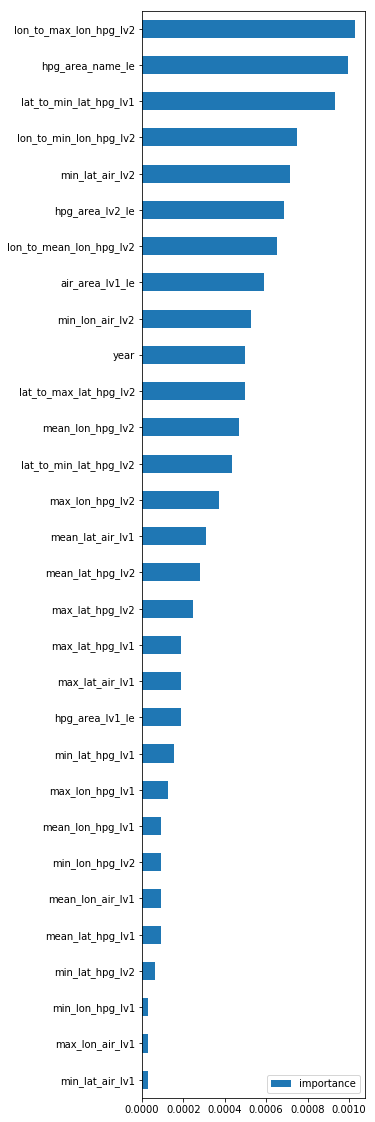

In [25]:
model.feature_names = full_vars
feature_importance = pd.DataFrame.from_dict(model.get_fscore(), orient='index')
feature_importance.columns = ['importance']
feature_importance.importance = feature_importance.importance/ feature_importance.importance.sum()
feature_importance.sort_values(by='importance').head(30).plot(kind='barh',figsize=(4,20))
feature_importance.sort_values(by='importance',ascending=False).head(30)

In [26]:
train_x = train[full_vars].values
train_y = np.log1p(train['visitors'].values)
model = xgb.train(best_xgb_params, 
                  xgb.DMatrix(train_x, label=train_y), 
                  num_boost_round=best_iteration)    
test['visitors'] = model.predict(xgb.DMatrix(test[full_vars].values))
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub = test[['id','visitors']].copy()
sub[['id', 'visitors']].to_csv('../output/sub_starter.csv', index=False)

/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [27]:
default_xgb_params = {}
default_xgb_params["objective"] = "reg:linear"
default_xgb_params["eta"] = 0.1
default_xgb_params["seed"] = 1234

params_xgb_space = {}
params_xgb_space['max_depth'] = [4,5,6,7,8,9,10]
params_xgb_space['gamma'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_xgb_space['colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_xgb_space['subsample'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_xgb_space['min_child_weight'] = [0, 1, 3, 10, 30, 100]

greater_is_better = False

In [28]:
best_xgb_params = default_xgb_params
for p in params_xgb_space:
    print ("Tuning parameter %s in %s" % (p, params_xgb_space[p]))

    params = best_xgb_params
    scores = []    
    for v in params_xgb_space[p]:
        print ('    %s: %s' % (p, v), end="")
        params[p] = v
        model = xgb.train(params, 
                      xgtrain, 
                      num_boost_round=100000,
                      evals=watchlist,
                      early_stopping_rounds=50,
                      verbose_eval=False)    
        best_iteration = model.best_iteration
        best_score = model.best_score
        print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))
        scores.append([v, best_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_xgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))
    

Tuning parameter max_depth in [4, 5, 6, 7, 8, 9, 10]
    max_depth: 4, best_score: 0.467016, best_iteration: 729
    max_depth: 5, best_score: 0.464928, best_iteration: 560
    max_depth: 6, best_score: 0.465877, best_iteration: 379
    max_depth: 7, best_score: 0.468971, best_iteration: 333
    max_depth: 8, best_score: 0.471973, best_iteration: 106
    max_depth: 9, best_score: 0.471527, best_iteration: 103
    max_depth: 10, best_score: 0.469575, best_iteration: 68
Best max_depth is 5 with a score of 0.464928
Tuning parameter gamma in [0, 0.1, 0.3, 1, 1.5, 2, 3]
    gamma: 0, best_score: 0.464928, best_iteration: 560
    gamma: 0.1, best_score: 0.467395, best_iteration: 598
    gamma: 0.3, best_score: 0.465242, best_iteration: 564
    gamma: 1, best_score: 0.470462, best_iteration: 259
    gamma: 1.5, best_score: 0.480802, best_iteration: 161
    gamma: 2, best_score: 0.475657, best_iteration: 197
    gamma: 3, best_score: 0.485906, best_iteration: 110
Best gamma is 0 with a score o

In [29]:
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'reg:linear'
    params['eta'] = 0.1
    params['max_depth'] = int(max_depth )   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['seed'] = 1234    


    model = xgb.train(params, 
                  xgtrain, 
                  num_boost_round=100000,
                  evals=watchlist,
                  early_stopping_rounds=50,
                  verbose_eval=False)    
    best_iteration = model.best_iteration
    best_score = model.best_score

    print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))

    return -best_score


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (5, 11),
                              'min_child_weight': (0, 200),
                              'colsample_bytree': (0.2, 1),
                              'subsample': (0.7, 1),
                              'gamma': (0, 3)
                             }
                            )

xgb_BO.maximize(init_points=8, n_iter=42)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
, best_score: 0.467008, best_iteration: 793
    1 | 03m05s |   -0.46701 |             0.4389 |    0.5229 |      5.7010 |            74.3639 |      0.8201 | 
, best_score: 0.463726, best_iteration: 297
    2 | 03m36s |   -0.46373 |             0.6888 |    1.5101 |     10.8142 |            90.9411 |      0.8949 | 
, best_score: 0.465382, best_iteration: 405
    3 | 04m01s |   -0.46538 |             0.5527 |    2.2947 |     10.4017 |            15.0209 |      0.8668 | 
, best_score: 0.466164, best_iteration: 158
    4 | 02m29s |   -0.46616 |             0.8286 |    0.7567 |      9.6438 |            61.3067 |      0.7759 | 
, best_score: 0.463995, best_iteration: 325
    5 | 03m04s |   -0.46399 |             0.6951 |    0.2008 |      7.4076 |            

/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  3.40229362e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.461006, best_iteration: 767
   10 | 10m25s |   -0.46101 |             0.9153 |    2.8863 |     10.7616 |           199.7859 |      0.9042 | 
, best_score: 0.461291, best_iteration: 931
   11 | 08m21s |   -0.46129 |             0.9931 |    2.9658 |      5.1916 |           127.9086 |      0.7267 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00016882]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.464826, best_iteration: 974
   12 | 06m11s |   -0.46483 |             0.9844 |    2.8646 |      5.3045 |             1.4934 |      0.9752 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.63093261e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.461723, best_iteration: 677
   13 | 05m11s |   -0.46172 |             0.9738 |    2.9993 |      5.3155 |           197.1809 |      0.8106 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -7.72714397e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.470683, best_iteration: 73
   14 | 02m19s |   -0.47068 |             0.9971 |    0.5011 |     10.9407 |             0.5908 |      0.7278 | 
, best_score: 0.460501, best_iteration: 1306
   15 | 10m09s |   -0.46050 |             0.9402 |    2.9634 |      5.0770 |            92.4384 |      0.7178 | 
, best_score: 0.465818, best_iteration: 442
   16 | 03m57s |   -0.46582 |             0.9984 |    1.7663 |      5.1823 |            18.2012 |      0.7279 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.46654612e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  6.94350143e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.463026, best_iteration: 232
   17 | 04m24s |   -0.46303 |             0.9969 |    0.0840 |     10.7874 |           146.3868 |      0.7810 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.70795684e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.461293, best_iteration: 782
   18 | 05m00s |   -0.46129 |             0.9773 |    0.2568 |      5.0303 |           143.9784 |      0.9941 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.08102140e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.461411, best_iteration: 538
   19 | 03m47s |   -0.46141 |             0.9911 |    0.1518 |      5.4945 |           121.3992 |      0.9678 | 
, best_score: 0.462031, best_iteration: 280
   20 | 05m14s |   -0.46203 |             0.9795 |    2.9576 |     10.9589 |            19.5969 |      0.7294 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -5.30202087e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.463752, best_iteration: 232
   21 | 04m29s |   -0.46375 |             0.9895 |    0.4782 |     10.1963 |           198.4941 |      0.7066 | 
, best_score: 0.461594, best_iteration: 1029
   22 | 06m49s |   -0.46159 |             0.9975 |    2.9304 |      5.2231 |           160.2798 |      0.9446 | 
, best_score: 0.465192, best_iteration: 624
   23 | 04m10s |   -0.46519 |             0.9920 |    2.6817 |      5.3260 |           107.0768 |      0.9894 | 
, best_score: 0.473460, best_iteration: 1074
   24 | 03m02s |   -0.47346 |             0.2684 |    2.4512 |      5.8002 |           199.9831 |      0.7465 | 
, best_score: 0.460479, best_iteration: 672
   25 | 04m22s |   -0.46048 |             0.9901 |    0.4078 |      5.6531 |            88.5359 |      0.9948 | 
, best_score: 0.464076, best_iteration: 230
   26 | 03m50s |   -0.46408 |             0.9774 |    0.1897 |     10.8382 |           126.1627 |      0.9431 | 
, best_score: 0.461411, best_iteration: 664
   27 | 08m0

/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00023511]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.462629, best_iteration: 554
   41 | 09m23s |   -0.46263 |             0.9860 |    2.9435 |     10.6145 |           159.6206 |      0.7151 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00032573]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.464277, best_iteration: 170
   42 | 03m42s |   -0.46428 |             0.9976 |    0.1511 |     10.7602 |            78.6038 |      0.7043 | 
, best_score: 0.465004, best_iteration: 338
   43 | 03m46s |   -0.46500 |             0.9989 |    2.8512 |      8.1921 |            95.3928 |      0.9964 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00021182]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.480110, best_iteration: 504
   44 | 02m00s |   -0.48011 |             0.2023 |    2.9755 |      9.5738 |            83.2293 |      0.8477 | 
, best_score: 0.463659, best_iteration: 179
   45 | 03m45s |   -0.46366 |             0.9927 |    0.1767 |     10.9172 |           112.1625 |      0.7274 | 
, best_score: 0.462658, best_iteration: 674
   46 | 05m38s |   -0.46266 |             0.9735 |    2.9005 |      5.9913 |            65.2750 |      0.7137 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00014696]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00045906]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.461127, best_iteration: 657
   47 | 05m23s |   -0.46113 |             0.9496 |    0.4547 |      5.5457 |            45.6030 |      0.7166 | 
, best_score: 0.464835, best_iteration: 523
   48 | 04m33s |   -0.46483 |             0.9868 |    2.8227 |      5.1066 |           148.4192 |      0.7141 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  2.35266848e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.460417, best_iteration: 821
   49 | 08m02s |   -0.46042 |             0.9798 |    2.8394 |      6.8623 |           115.8101 |      0.7121 | 
, best_score: 0.480591, best_iteration: 669
   50 | 01m55s |   -0.48059 |             0.2461 |    2.7756 |      5.2361 |             5.9360 |      0.7156 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00080374]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


In [30]:
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.head()

,colsample_bytree,gamma,max_depth,min_child_weight,subsample,score
0,0.962067,0.048045,5.666450,199.894755,0.896361,-0.459792
23,0.983733,2.781115,5.015299,172.173951,0.742330,-0.459851
40,0.979780,2.839364,6.862328,115.810147,0.712138,-0.460417
16,0.990121,0.407790,5.653085,88.535936,0.994784,-0.460479
6,0.940194,2.963421,5.076972,92.438378,0.717783,-0.460501


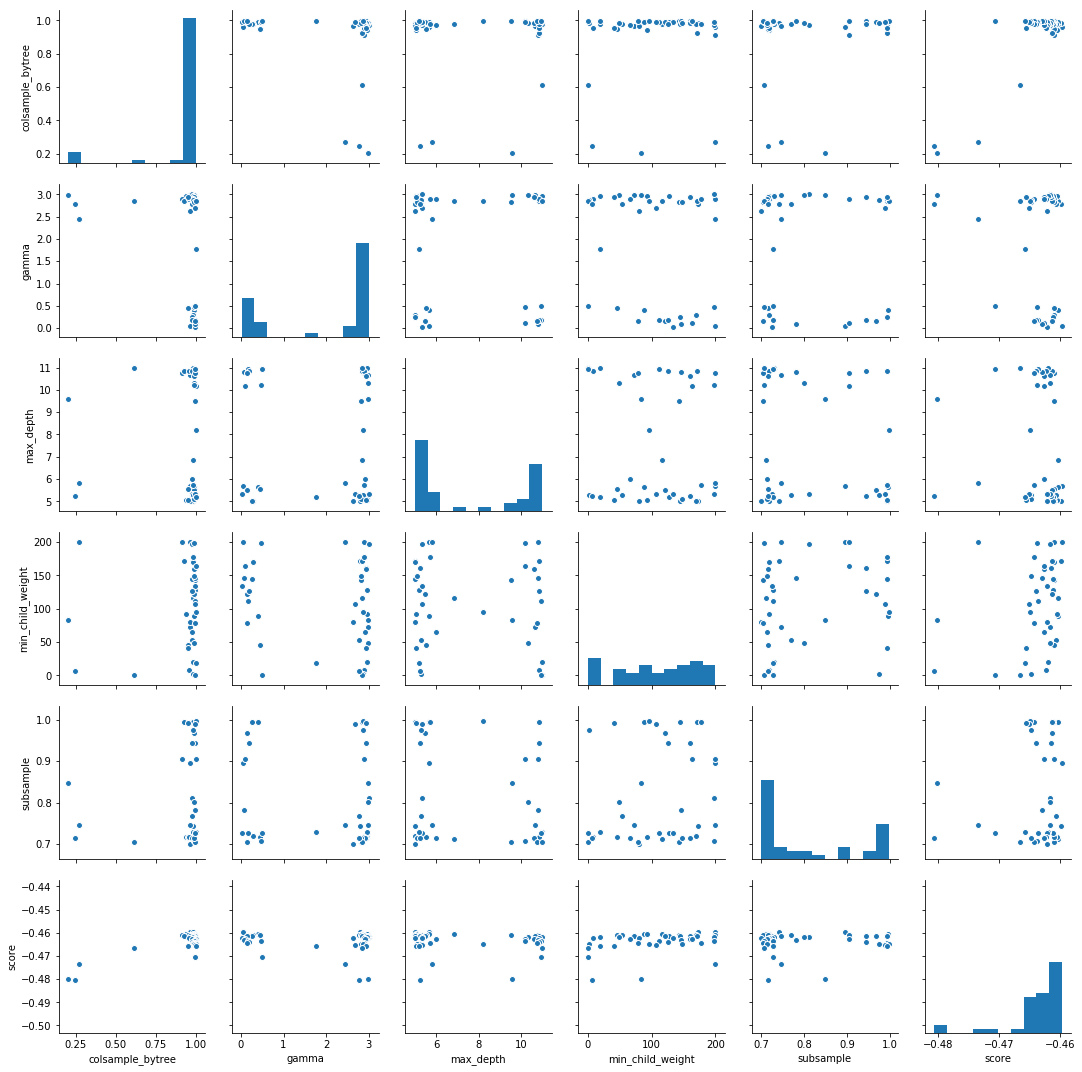

In [31]:
sns.pairplot(xgb_BO_scores)

In [32]:
best_xgb_params = xgb_BO_scores.iloc[0].to_dict()
best_xgb_params['objective'] = 'reg:linear'

# best_xgb_params['eta'] = 0.01 
# Typically we would want to use a smaller learning rate which doesn't seem to work for this competition so
# we will be using a regular one, i.e. 0.1 instead
best_xgb_params['eta'] = 0.1  # Smaller

best_xgb_params['max_depth'] = int(best_xgb_params['max_depth'])
best_xgb_params['min_child_weight'] = int(best_xgb_params['min_child_weight'])
best_xgb_params['subsample'] = best_xgb_params['subsample']
best_xgb_params['colsample_bytree'] = best_xgb_params['colsample_bytree']
best_xgb_params['gamma'] = best_xgb_params['gamma']
best_xgb_params['seed'] = 1234

best_xgb_params

train_x = train[(train['visit_date']<=datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date()) 
      & (train['visit_date']>datetime.datetime.strptime('2016-04-01', '%Y-%m-%d').date())][full_vars].values
train_y = np.log1p(train[(train['visit_date']<=datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date()) 
      & (train['visit_date']>datetime.datetime.strptime('2016-04-01', '%Y-%m-%d').date())]['visitors'].values)

val_x = train[(train['visit_date']>datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date())][full_vars].values
val_y = np.log1p(train[(train['visit_date']>datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date())]['visitors'].values)
print (train_x.shape, val_x.shape, train_x.shape[0]+ val_x.shape[0])


xgtrain = xgb.DMatrix(train_x, label=train_y)
xgval=xgb.DMatrix(val_x,label=val_y)

watchlist  = [ (xgtrain,'train'),(xgval,'eval')]

print (best_xgb_params)

model = xgb.train(best_xgb_params, 
                  xgtrain, 
                  num_boost_round=100000,
                  evals=watchlist,
                  early_stopping_rounds=50,
                  verbose_eval=50)    
best_xgb_iteration = model.best_iteration
best_xgb_score = model.best_score
print ('best_score: %f, best_iteration: %d' % (best_xgb_score, best_xgb_iteration))



(197019, 97) (31591, 97) 228610
{'colsample_bytree': 0.96206695591674607, 'gamma': 0.04804540209234176, 'max_depth': 5, 'min_child_weight': 199, 'subsample': 0.89636128896322265, 'score': -0.45979199999999998, 'objective': 'reg:linear', 'eta': 0.1, 'seed': 1234}
[0]	train-rmse:2.19664	eval-rmse:2.25205
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.484861	eval-rmse:0.493778
[100]	train-rmse:0.479186	eval-rmse:0.483789
[150]	train-rmse:0.474737	eval-rmse:0.476564
[200]	train-rmse:0.471863	eval-rmse:0.471038
[250]	train-rmse:0.46869	eval-rmse:0.467358
[300]	train-rmse:0.466633	eval-rmse:0.464226
[350]	train-rmse:0.465137	eval-rmse:0.463409
[400]	train-rmse:0.46345	eval-rmse:0.462557
[450]	train-rmse:0.461947	eval-rmse:0.462306
[500]	train-rmse:0.46065	eval-rmse:0.461337
[550]	train-rmse:0.459231	eval-rmse:0.460276
[600]	train-rmse:0.458285	eval-rmse:0.460067
[650]	train-rmse:

In [33]:
train_x = train[full_vars].values
train_y = np.log1p(train['visitors'].values)


model = xgb.train(best_xgb_params, 
                  xgb.DMatrix(train_x, label=train_y), 
                  num_boost_round=best_xgb_iteration)    
test['visitors'] = model.predict(xgb.DMatrix(test[full_vars].values))
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub = test[['id','visitors']].copy()
sub[['id', 'visitors']].to_csv('../output/sub_xgb_tuned_params_smaller_eta.csv', index=False)

/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [34]:
default_lgb_params = {}
default_lgb_params["objective"] = "regression"
default_lgb_params["learning_rate"] = 0.1
default_lgb_params["metric"] = 'l2_root'
default_lgb_params["nthread"] = -1
default_lgb_params["seed"] = 1234

params_lgb_space = {}
params_lgb_space['max_bin'] = [127, 255, 511, 1023]
params_lgb_space['num_leaves'] = [15, 31, 63, 127, 255, 511, 1023]
params_lgb_space['min_gain_to_split'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_lgb_space['feature_fraction'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_lgb_space['bagging_fraction'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_lgb_space['bagging_freq'] = [1, 3, 5]
params_lgb_space['min_sum_hessian_in_leaf'] = [1, 5, 10, 30, 100]
params_lgb_space['lambda_l2'] = [0, 0.01, 0.1, 1, 10, 100]
params_lgb_space['lambda_l1'] = [0, 0.01, 0.1, 1, 10, 100]


greater_is_better = False

In [35]:
train_x = train[(train['visit_date']<=datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date()) 
      & (train['visit_date']>datetime.datetime.strptime('2016-04-01', '%Y-%m-%d').date())][full_vars].values
train_y = np.log1p(train[(train['visit_date']<=datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date()) 
      & (train['visit_date']>datetime.datetime.strptime('2016-04-01', '%Y-%m-%d').date())]['visitors'].values)

val_x = train[(train['visit_date']>datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date())][full_vars].values
val_y = np.log1p(train[(train['visit_date']>datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date())]['visitors'].values)
best_lgb_params = default_lgb_params
lgtrain = lgb.Dataset(train_x, train_y)
lgval = lgb.Dataset(val_x, val_y, reference=lgtrain)

In [36]:
for p in params_lgb_space:
    print ("Tuning parameter %s in %s" % (p, params_lgb_space[p]))

    params = best_lgb_params
    scores = []    
    for v in params_lgb_space[p]:
        print ('    %s: %s' % (p, v), end="")
        params[p] = v
        
## Following is the sample code for LightGBM CV        
#         cv_results = lgb.cv(params, 
#                             lgtrain,
#                             nfold=4,   
#                             num_boost_round=100000,
#                             early_stopping_rounds=50,
#                             verbose_eval=False,
#                             metrics='rmse',
#                            stratified=False,
#                             categorical_feature='',
#                            shuffle=False)    
#         best_iteration = len(cv_results)
#         best_score = cv_results['test-rmse-mean'].min()

        model = lgb.train(params, 
                      lgtrain, 
                      num_boost_round=100000,
                      valid_sets=lgval,
                      categorical_feature='',
                      early_stopping_rounds=50,
                      verbose_eval=False)    
        best_iteration = model.best_iteration
        best_score = model.best_score['valid_0']['rmse']
        print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))
        scores.append([v, best_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_lgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('Best manually tuned parameters:', best_lgb_params)    



Tuning parameter max_bin in [127, 255, 511, 1023]
    max_bin: 127

/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


, best_score: 0.463385, best_iteration: 420
    max_bin: 255, best_score: 0.463385, best_iteration: 420
    max_bin: 511, best_score: 0.463385, best_iteration: 420
    max_bin: 1023, best_score: 0.463385, best_iteration: 420
Best max_bin is 127 with a score of 0.463385
Tuning parameter num_leaves in [15, 31, 63, 127, 255, 511, 1023]
    num_leaves: 15, best_score: 0.464118, best_iteration: 582
    num_leaves: 31, best_score: 0.463385, best_iteration: 420
    num_leaves: 63, best_score: 0.462629, best_iteration: 175
    num_leaves: 127, best_score: 0.464184, best_iteration: 117
    num_leaves: 255, best_score: 0.465951, best_iteration: 102
    num_leaves: 511, best_score: 0.468910, best_iteration: 64
    num_leaves: 1023, best_score: 0.473018, best_iteration: 43
Best num_leaves is 63 with a score of 0.462629
Tuning parameter min_gain_to_split in [0, 0.1, 0.3, 1, 1.5, 2, 3]
    min_gain_to_split: 0, best_score: 0.462629, best_iteration: 175
    min_gain_to_split: 0.1, best_score: 0.46378

In [37]:
def lgb_evaluate(max_bin,
                 num_leaves,
                 min_sum_hessian_in_leaf,
                 min_gain_to_split,
                 feature_fraction,
                 bagging_fraction,
                 bagging_freq,
                 lambda_l1,
                 lambda_l2
                 ):
    params = dict()
    params['objective'] = 'regression'
    params['learning_rate'] = 0.1
    params['max_bin'] = int(max_bin)
    params['num_leaves'] = int(num_leaves)    
    params['min_sum_hessian_in_leaf'] = int(min_sum_hessian_in_leaf)
    params['min_gain_to_split'] = min_gain_to_split    
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = int(bagging_freq)
    params["metric"] = 'l2_root'
    params["nthread"] = -1    


    model = lgb.train(params, 
                  lgtrain, 
                  num_boost_round=100000,
                  valid_sets=lgval,
                  categorical_feature='',
                  early_stopping_rounds=50,
                  verbose_eval=False)    
    best_iteration = model.best_iteration
    best_score = model.best_score['valid_0']['rmse']
    print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))

    return -best_score


lgb_BO = BayesianOptimization(lgb_evaluate, 
                             {'max_bin': (255, 255),
                              'num_leaves': (7, 31),
                              'min_sum_hessian_in_leaf': (1, 10),
                              'min_gain_to_split': (0,2),
                              'feature_fraction': (0.1, 0.3),
                              'bagging_fraction': (0.8,1),
                              'bagging_freq': (1,5),
                              'lambda_l1': (0,1),
                              'lambda_l2': (0,1)
                             }
                            )

lgb_BO.maximize(init_points=5, n_iter=45)





Initialization
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_bin |   min_gain_to_split |   min_sum_hessian_in_leaf |   num_leaves | 
, best_score: 0.481499, best_iteration: 116
    1 | 00m05s |   -0.48150 |             0.9209 |         4.6929 |             0.2650 |      0.2304 |      0.5328 |  255.0000 |              1.0456 |                    8.2086 |      18.6117 | 
, best_score: 0.488861, best_iteration: 177
    2 | 00m07s |   -0.48886 |             0.8178 |         2.2736 |             0.1572 |      0.8585 |      0.8588 |  255.0000 |              0.6995 |                    6.1799 |      24.5778 | 
, best_score: 0.488712, best_iteration: 150
    3 | 00m06s |   -0.48871 |             0.9800 |         4.6069 |       

/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.69313577e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.478032, best_iteration: 183
   10 | 00m24s |   -0.47803 |             0.9922 |         4.9468 |             0.2811 |      0.9537 |      0.1816 |  255.0000 |              0.1085 |                    9.8857 |      16.5898 | 
, best_score: 0.487877, best_iteration: 177
   11 | 00m26s |   -0.48788 |             0.8271 |         4.9223 |             0.1449 |      0.9267 |      0.0737 |  255.0000 |              0.0413 |                    2.4796 |      18.4111 | 
, best_score: 0.482277, best_iteration: 167
   12 | 00m14s |   -0.48228 |             0.9760 |         1.0960 |             0.2987 |      0.4606 |      0.3732 |  255.0000 |              1.6785 |                    9.5671 |       7.1169 | 
, best_score: 0.482304, best_iteration: 166
   13 | 00m15s |   -0.48230 |             0.9321 |         4.9781 |             0.2971 |      0.5273 |      0.4202 |  255.0000 |              1.9859 |                    9.9174 |       7.2381 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -8.43437647e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.481110, best_iteration: 260
   14 | 00m17s |   -0.48111 |             1.0000 |         1.3442 |             0.3000 |      0.0000 |      0.0000 |  255.0000 |              0.0967 |                    1.2381 |       7.0699 | 
, best_score: 0.482812, best_iteration: 167
   15 | 00m16s |   -0.48281 |             1.0000 |         3.9599 |             0.3000 |      1.0000 |      0.8879 |  255.0000 |              2.0000 |                    1.2286 |       7.0000 | 
, best_score: 0.482998, best_iteration: 105
   16 | 00m17s |   -0.48300 |             0.9858 |         1.7347 |             0.2975 |      0.7710 |      0.0547 |  255.0000 |              1.9926 |                    1.3318 |      20.9709 | 
, best_score: 0.480414, best_iteration: 105
   17 | 00m21s |   -0.48041 |             1.0000 |         5.0000 |             0.3000 |      1.0000 |      0.0000 |  255.0000 |              2.0000 |                    6.6732 |      23.9602 | 
, best_score: 0.476181, best_iteration: 254


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.00578700e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.480715, best_iteration: 217
   20 | 00m26s |   -0.48072 |             1.0000 |         4.9667 |             0.3000 |      0.0000 |      1.0000 |  255.0000 |              0.2175 |                    7.9885 |       7.9315 | 
, best_score: 0.477743, best_iteration: 117
   21 | 00m27s |   -0.47774 |             0.9520 |         4.9088 |             0.2580 |      0.9995 |      0.9227 |  255.0000 |              0.3454 |                    2.1660 |      30.6155 | 
, best_score: 0.482443, best_iteration: 116
   22 | 00m26s |   -0.48244 |             0.8992 |         1.3410 |             0.2924 |      0.1760 |      0.9114 |  255.0000 |              1.9723 |                    1.5502 |      10.1068 | 
, best_score: 0.472560, best_iteration: 380
   23 | 00m33s |   -0.47256 |             0.9401 |         1.1872 |             0.2845 |      0.5447 |      0.9048 |  255.0000 |              0.0181 |                    9.4068 |      30.8325 | 
, best_score: 0.472466, best_iteration: 324


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.74871238e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.476122, best_iteration: 258
   30 | 00m32s |   -0.47612 |             0.9736 |         1.0701 |             0.2953 |      0.9562 |      0.8578 |  255.0000 |              0.0630 |                    2.2119 |      18.4518 | 
, best_score: 0.476391, best_iteration: 118
   31 | 00m27s |   -0.47639 |             0.9390 |         1.2903 |             0.2966 |      0.8585 |      0.0017 |  255.0000 |              0.0477 |                    9.4165 |      28.1391 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00064579]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.474617, best_iteration: 386
   32 | 00m35s |   -0.47462 |             0.9968 |         1.4099 |             0.2983 |      0.8878 |      0.9517 |  255.0000 |              0.0418 |                    9.4809 |      16.3527 | 
, best_score: 0.476239, best_iteration: 206
   33 | 00m31s |   -0.47624 |             0.8667 |         1.0262 |             0.2685 |      0.0629 |      0.9797 |  255.0000 |              0.1905 |                    1.8047 |      30.8933 | 
, best_score: 0.479506, best_iteration: 118
   34 | 00m27s |   -0.47951 |             0.9625 |         1.0216 |             0.2936 |      0.4270 |      0.2449 |  255.0000 |              0.0880 |                    5.8542 |      18.7218 | 
, best_score: 0.477711, best_iteration: 389
   35 | 00m32s |   -0.47771 |             0.9608 |         1.1386 |             0.2703 |      0.9933 |      0.9632 |  255.0000 |              0.1110 |                    4.7480 |       9.6434 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00022006]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.477638, best_iteration: 117
   36 | 00m28s |   -0.47764 |             0.9946 |         1.3479 |             0.2856 |      0.7556 |      0.9162 |  255.0000 |              0.1745 |                    9.2190 |      25.5881 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00017134]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.475348, best_iteration: 411
   37 | 00m32s |   -0.47535 |             0.8166 |         1.3188 |             0.2875 |      0.8586 |      0.1067 |  255.0000 |              0.1719 |                    9.7017 |      11.1822 | 
, best_score: 0.472572, best_iteration: 409
   38 | 00m36s |   -0.47257 |             0.9177 |         4.7090 |             0.2998 |      0.8971 |      0.9634 |  255.0000 |              0.1828 |                    1.7443 |      24.7549 | 
, best_score: 0.482591, best_iteration: 109
   39 | 00m28s |   -0.48259 |             0.9977 |         1.2737 |             0.2850 |      0.9873 |      0.0609 |  255.0000 |              1.9885 |                    9.5869 |      12.5605 | 
, best_score: 0.481076, best_iteration: 216
   40 | 00m31s |   -0.48108 |             0.9613 |         1.0881 |             0.2952 |      0.9312 |      0.5134 |  255.0000 |              0.2902 |                    9.6700 |       7.4929 | 
, best_score: 0.474496, best_iteration: 371


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00033832]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.479173, best_iteration: 193
   47 | 00m32s |   -0.47917 |             0.9927 |         1.1960 |             0.2963 |      0.8566 |      0.0904 |  255.0000 |              0.3952 |                    1.0730 |      13.2063 | 


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00019519]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00045389]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


, best_score: 0.473481, best_iteration: 300
   48 | 00m35s |   -0.47348 |             0.9837 |         1.1023 |             0.2971 |      0.3148 |      0.2264 |  255.0000 |              0.0174 |                    4.6926 |      30.8526 | 
, best_score: 0.474863, best_iteration: 255
   49 | 00m33s |   -0.47486 |             0.9855 |         4.9498 |             0.2967 |      0.9729 |      0.9476 |  255.0000 |              0.1898 |                    6.0453 |      25.4849 | 
, best_score: 0.480574, best_iteration: 208
   50 | 00m29s |   -0.48057 |             0.8434 |         1.0047 |             0.2909 |      0.8595 |      0.1090 |  255.0000 |              0.7403 |                    4.8861 |       7.1057 | 


In [38]:
lgb_BO_scores = pd.DataFrame(lgb_BO.res['all']['params'])
lgb_BO_scores['score'] = pd.DataFrame(lgb_BO.res['all']['values'])
lgb_BO_scores = lgb_BO_scores.sort_values(by='score',ascending=False)
lgb_BO_scores.head()

,bagging_fraction,bagging_freq,feature_fraction,lambda_l1,lambda_l2,max_bin,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,score
18,0.992777,4.817545,0.293587,0.949009,0.647327,255.0,0.017474,9.496786,27.164863,-0.472466
17,0.940051,1.187160,0.284523,0.544667,0.904827,255.0,0.018078,9.406848,30.832499,-0.472560
32,0.917731,4.708981,0.299824,0.897110,0.963408,255.0,0.182759,1.744337,24.754887,-0.472572
38,0.829228,3.784668,0.297158,0.850886,0.301841,255.0,0.030985,9.906087,25.856733,-0.473258
42,0.983657,1.102296,0.297112,0.314764,0.226368,255.0,0.017442,4.692644,30.852608,-0.473481


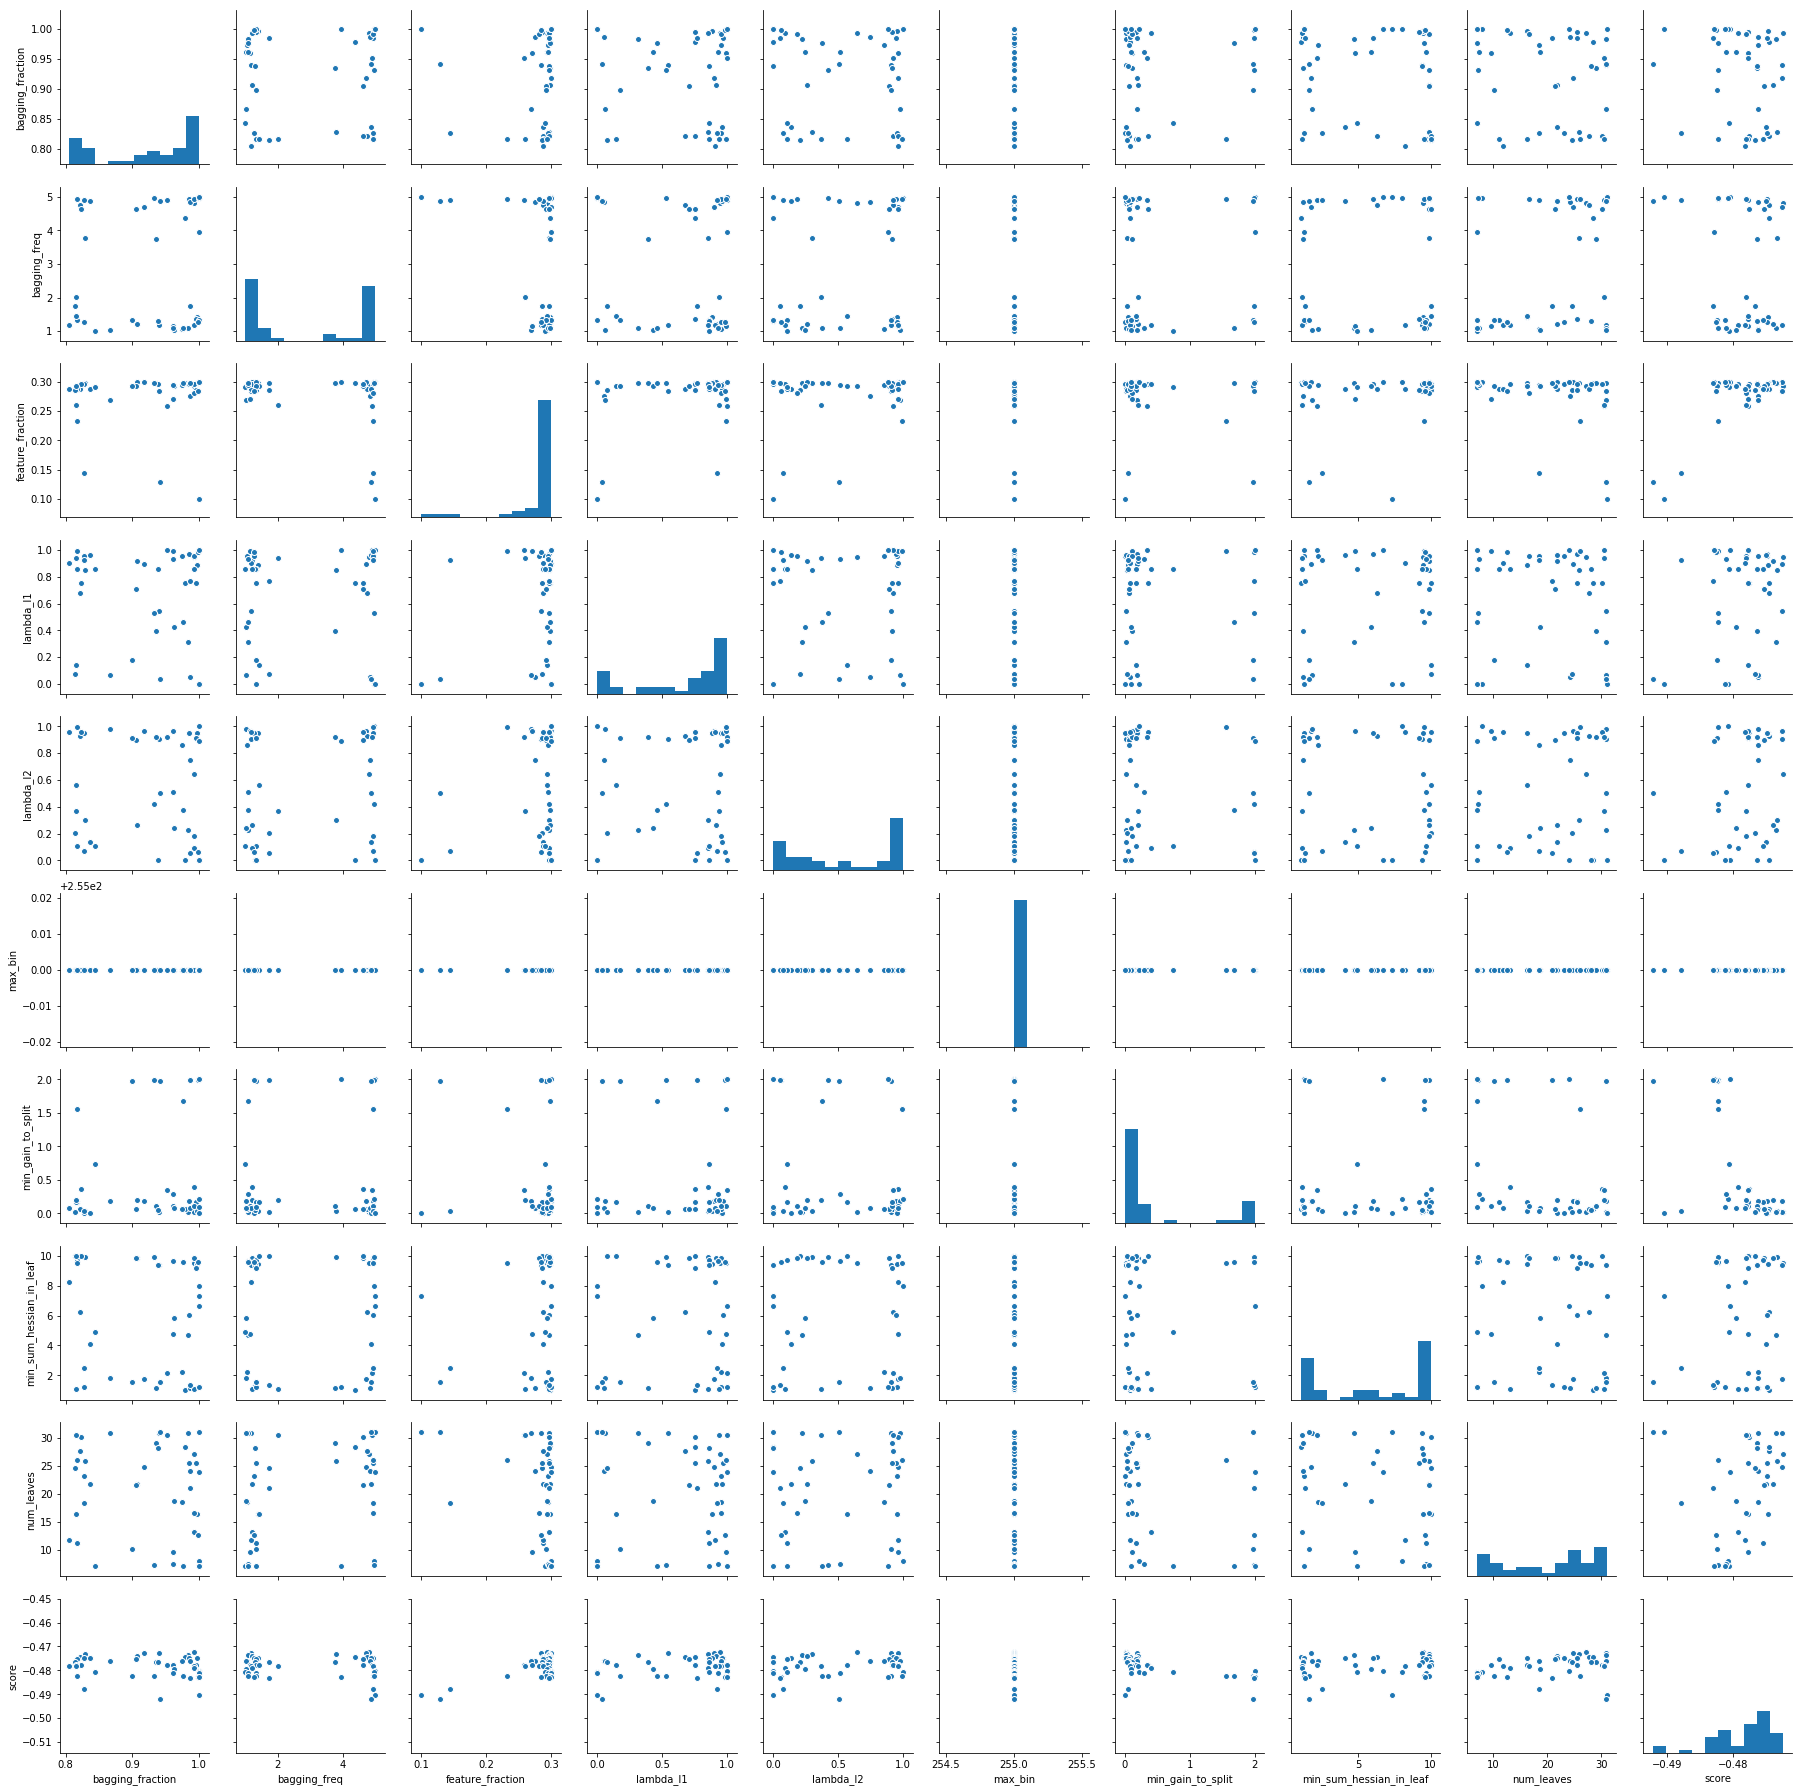

In [39]:
sns.pairplot(lgb_BO_scores)

In [40]:
params = lgb_BO_scores.iloc[0].to_dict()
best_lgb_params = dict()
best_lgb_params['objective'] = 'regression'
best_lgb_params["metric"] = 'l2_root'
# best_lgb_params['learning_rate'] = 0.01 
# Typically we would want to use a smaller learning rate which doesn't seem to work for this competition so
# we will be using a regular one, i.e. 0.1 instead
best_lgb_params['learning_rate'] = 0.1 # Smaller learning rate


best_lgb_params['max_bin'] = int(params['max_bin'])   
best_lgb_params['num_leaves'] = int(params['num_leaves'])    
best_lgb_params['min_sum_hessian_in_leaf'] = int(params['min_sum_hessian_in_leaf'])
best_lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
best_lgb_params['feature_fraction'] = params['feature_fraction']
best_lgb_params['bagging_fraction'] = params['bagging_fraction']
best_lgb_params['bagging_freq'] = 1



model = lgb.train(best_lgb_params, 
              lgtrain, 
              num_boost_round=100000,
              valid_sets=lgval,
              categorical_feature='',
              early_stopping_rounds=50,
              verbose_eval=False)    
best_lgb_iteration = model.best_iteration
best_lgb_score = model.best_score['valid_0']['rmse']

## You can also try to use CV
# cv_results = lgb.cv(best_lgb_params, 
#                     lgtrain,
#                     nfold=5,   
#                     num_boost_round=100000,
#                     early_stopping_rounds=200,
#                     verbose_eval=False,
#                     metrics='rmse',
#                    stratified=False,
#                     categorical_feature='',
#                    shuffle=False)    
# best_lgb_iteration = len(cv_results)
# best_lgb_score = pd.DataFrame(cv_results)['rmse-mean'].min()


print ('best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))



best_score: 0.474134, best_iteration: 258


In [41]:
train_x = train[full_vars].values
train_y = np.log1p(train['visitors'].values)


model = lgb.train(best_lgb_params, 
                  lgb.Dataset(train_x, label=train_y), 
                  num_boost_round=best_lgb_iteration)    
test['visitors'] = model.predict(test[full_vars].values)
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub = test[['id','visitors']].copy()
sub[['id', 'visitors']].to_csv('../output/sub_lgb_tuned_params_smaller_eta.csv', index=False)



/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [42]:
# XGBoost
agg_xgb_preds = []
test_x = test[full_vars].values
for i in range(4):
    train_x = train[(train['visit_date']>=datetime.datetime.strptime('2016-{:02d}-01'.format(i+1), '%Y-%m-%d').date())]\
            [full_vars].values
    train_y = np.log1p(train[(train['visit_date']>=datetime.datetime.strptime('2016-{:02d}-01'.format(i+1), '%Y-%m-%d').date())]['visitors'].values)
    print (train_x.shape, train_y.shape)
    
    model = xgb.train(best_xgb_params, 
                  xgb.DMatrix(train_x, label=train_y), 
                  num_boost_round=best_xgb_iteration)    
    preds = np.expm1(model.predict(xgb.DMatrix(test_x)))
    agg_xgb_preds.append(preds)
    
test['visitors'] = np.array(agg_xgb_preds).mean(axis=0)
sub = test[['id','visitors']].copy()
sub[['id', 'visitors']].to_csv('../output/sub_xgb_ensemble_by_mon.csv', index=False)
    

(252108, 97) (252108,)
(244788, 97) (244788,)
(237184, 97) (237184,)
(228906, 97) (228906,)


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [43]:
# LightGBM
agg_lgb_preds = []
test_x = test[full_vars].values
for i in range(4):
    train_x = train[(train['visit_date']>=datetime.datetime.strptime('2016-{:02d}-01'.format(i+1), '%Y-%m-%d').date())]\
            [full_vars].values
    train_y = np.log1p(train[(train['visit_date']>=datetime.datetime.strptime('2016-{:02d}-01'.format(i+1), '%Y-%m-%d').date())]['visitors'].values)
    print (train_x.shape, train_y.shape)
    
    model = lgb.train(best_lgb_params, 
                  lgb.Dataset(train_x, label=train_y), 
                  num_boost_round=best_lgb_iteration)    
    test['visitors'] = model.predict(test_x)
    test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
    preds = np.expm1(model.predict(test_x))
    agg_lgb_preds.append(preds)
    
test['visitors'] = np.array(agg_lgb_preds).mean(axis=0)
sub = test[['id','visitors']].copy()
sub[['id', 'visitors']].to_csv('../output/sub_lgb_ensemble_by_mon.csv', index=False)

(252108, 97) (252108,)


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


(244788, 97) (244788,)
(237184, 97) (237184,)
(228906, 97) (228906,)


/Users/wenyuewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
